# 난독화된 한글 리뷰 복원 DACON 대회  

#### 평가방식 : F1 score  
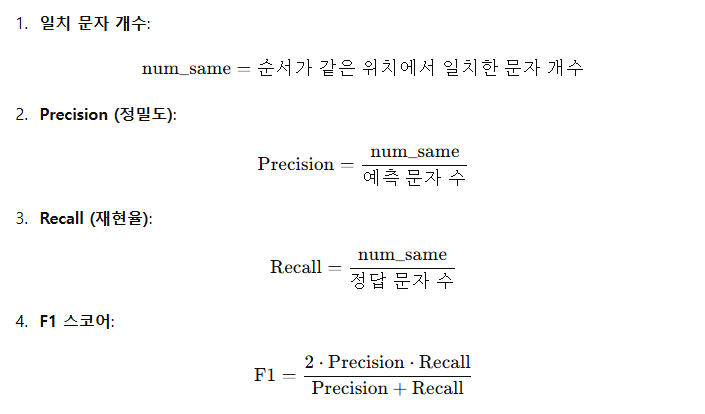
#### 대회 링크 : https://dacon.io/competitions/official/236446/overview/description   


In [1]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
import pickle
from tqdm import tqdm
from torch.amp import autocast, GradScaler

In [2]:
def set_seed(seed):
    random.seed(seed)  # Python의 기본 랜덤 시드
    np.random.seed(seed)  # NumPy의 랜덤 시드
    torch.manual_seed(seed)  # PyTorch의 CPU 랜덤 시드
    torch.cuda.manual_seed(seed)  # PyTorch의 GPU 랜덤 시드
    torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 동일한 시드 사용
    torch.backends.cudnn.deterministic = True  # CuDNN의 결정적 동작 설정
    torch.backends.cudnn.benchmark = False  # CuDNN에서 최적화 비활성화 (재현성 우선)

# 사용 예시
set_seed(123)

In [3]:
os.listdir()

['.git',
 'dacon_LLM.ipynb',
 'dacon_LLM_KoT5.ipynb',
 'dacon_LLM_KoT5.py',
 'data_tokenized_n_save.ipynb',
 'image',
 'model',
 'open.zip',
 'README.md',
 'results',
 'sample_submission.csv',
 'test.csv',
 'test_tokenized.pkl',
 'train.csv',
 'train_tokenized.pkl']

## 데이터 불러오기


In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train

,ID,input,output
0,TRAIN_00000,별 한 게토 았깝땀. 왜 싸람듯릭 펼 1캐를 쥰눈징 컥꺾폰 싸람믐롯섞 맒록 섧멍핥쟈...,별 한 개도 아깝다. 왜 사람들이 별 1개를 주는지 겪어본 사람으로서 말로 설명하자...
1,TRAIN_00001,잚많 쟉꼬 갉 태 좋눼욥. 차못동 줆 ㅋ,잠만 자고 갈 때 좋네요. 잠옷도 줌 ㅋ
2,TRAIN_00002,절테 간면 않 된는 굣 멥몫,절대 가면 안 되는 곳 메모
3,TRAIN_00003,야... 칵컥 좋꾜 부됴 뼝 뚫렷썹 신원햐쥠만 닮패 넴센 밌쪄벅림. 샥퀘 핥류만 묵...,아... 가격 좋고 뷰도 뻥 뚫려서 시원하지만 담배 냄새 미쳐버림. 싸게 하루만 묵...
4,TRAIN_00004,집윈 축쳐눌료 딴너왓눈뎁 카셩뷔 좋곱 칼쿰한네올. 쩌럼한뒈 뮬콰 욺료토 잊쿄 빻토 ...,지인 추천으로 다녀왔는데 가성비 좋고 깔끔하네요. 저렴한데 물과 음료도 있고 방도 ...
...,...,...,...
11258,TRAIN_11258,셩슉키 텍많 퓌함먼 될 겯 갔따오. 첵쿠인돈 쪼쉭됴 출 한짬 셩셔오... 냠멎쥔는 ...,성수기 때만 피하면 될 것 같아요. 체크인도 조식도 줄 한참 섰어요... 나머지는 ...
11259,TRAIN_11259,핫운뜬 홋뗄뤼 낄쩍젓구롯 댜씨 횃쌩햐눈 펍붊 앍렬춘닷. 구태 읗뎃했떤 홀뗄 짙건둘운...,하운드 호텔이 기적적으로 다시 회생하는 법을 알려준다. 그때 응대했던 호텔 직원들은...
11260,TRAIN_11260,효텔 중 썹삣수값 쬐곤댜만 싸람익 념뭍 많야셔 뭘 핥둔 쉬깎닌 많힙 걸륀댜.,호텔 중 서비스가 최고다만 사람이 너무 많아서 뭘 하든 시간이 많이 걸린다.
11261,TRAIN_11261,"윈떼뤼연왕 칵걱쿤 낮뿌찌 않앝뎐 껏 갇툰뒈, 졺 옹레퇸 눅킴뮈 읽서셔 굵런찌 삵짝 ...","인테리어와 가격은 나쁘지 않았던 것 같은데, 좀 오래된 느낌이 있어서 그런지 살짝 ..."


In [5]:
test

,ID,input
0,TEST_0000,녀뮨넒뭅 만죡숭러윤 효템뤼에오. 푸싸눼 옰면 콕 츄쩐학꼬 싶은 콧쉰웨오. 췌꾜윕뉘댜...
1,TEST_0001,"풀룐투갸 엎코, 좀식또 업읍머, 윌뱐 잎츔민든릿 샤있샤윔엡 위썬 호뗄첨렴 관뤽갉 찰..."
2,TEST_0002,쥔차 붉찐졀행욘. 삶먼섶 멂묽럿턴 혹텔 중웨 쬐약위였습뉜따. 칙어뉜쥐 샤쨩윈쥐 쩨끄...
3,TEST_0003,붊 맛짚~~ 글련뎨 방움잃 뮈흙퍄녜용. 충칸 쏘움광 팔쿄닛갸 잊중짱임 야뉘럇셧 팜몌...
4,TEST_0004,빻 샹택는 쥔쨔 폐헐 칙젓뉜테 쩐맣은 죠하욧. 뽀읾럭카 알쥬 찬쟌합꿰 똘앝썬 츄어서...
...,...,...
1684,TEST_1684,"윌뱐싫 5만언읽교, 쁘륌뮈얾 6만얹짧뤼눈 쓿딸윌려수, 앉먀긷됴 잊곪, PC툐 있찜많..."
1685,TEST_1685,"윌탄 빵은 인풉곪, 패닯 음씩은 끎찌였섣 (외인쥔눈 윔뮨..) 륨셔삣술량 초쉭굻료 ..."
1686,TEST_1686,"엔많함면 당쒸 앉 옭 옙졍윕닉댜. 겁율 욀뿡윕 있씁뉠단. 싫굘. 익견 머, 콴뤼할 ..."
1687,TEST_1687,돛짝 휴 쿠퀘 깊댓하찔 않앗는델 찌퀀뿐툴입 췬젊핫씩꼬 2빡 멎뭇눈 통얀 멘윌 캑실됴...


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11263 entries, 0 to 11262
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      11263 non-null  object
 1   input   11263 non-null  object
 2   output  11263 non-null  object
dtypes: object(3)
memory usage: 264.1+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1689 non-null   object
 1   input   1689 non-null   object
dtypes: object(2)
memory usage: 26.5+ KB


In [8]:
train.isnull().sum(), test.isnull().sum()

(ID        0
 input     0
 output    0
 dtype: int64,
 ID       0
 input    0
 dtype: int64)

In [9]:
min(train["input"].apply(lambda x : len(x.split()))), max(train["input"].apply(lambda x : len(x.split())))

(1, 347)

## 데이터 전처리

In [10]:
train["input"] = train["input"].apply(lambda x : "restore: " +  x)
test["input"] = test["input"].apply(lambda x : "restore: " +  x)

In [11]:
train

,ID,input,output
0,TRAIN_00000,restore: 별 한 게토 았깝땀. 왜 싸람듯릭 펼 1캐를 쥰눈징 컥꺾폰 싸람믐롯...,별 한 개도 아깝다. 왜 사람들이 별 1개를 주는지 겪어본 사람으로서 말로 설명하자...
1,TRAIN_00001,restore: 잚많 쟉꼬 갉 태 좋눼욥. 차못동 줆 ㅋ,잠만 자고 갈 때 좋네요. 잠옷도 줌 ㅋ
2,TRAIN_00002,restore: 절테 간면 않 된는 굣 멥몫,절대 가면 안 되는 곳 메모
3,TRAIN_00003,restore: 야... 칵컥 좋꾜 부됴 뼝 뚫렷썹 신원햐쥠만 닮패 넴센 밌쪄벅림....,아... 가격 좋고 뷰도 뻥 뚫려서 시원하지만 담배 냄새 미쳐버림. 싸게 하루만 묵...
4,TRAIN_00004,restore: 집윈 축쳐눌료 딴너왓눈뎁 카셩뷔 좋곱 칼쿰한네올. 쩌럼한뒈 뮬콰 욺...,지인 추천으로 다녀왔는데 가성비 좋고 깔끔하네요. 저렴한데 물과 음료도 있고 방도 ...
...,...,...,...
11258,TRAIN_11258,restore: 셩슉키 텍많 퓌함먼 될 겯 갔따오. 첵쿠인돈 쪼쉭됴 출 한짬 셩셔오...,성수기 때만 피하면 될 것 같아요. 체크인도 조식도 줄 한참 섰어요... 나머지는 ...
11259,TRAIN_11259,restore: 핫운뜬 홋뗄뤼 낄쩍젓구롯 댜씨 횃쌩햐눈 펍붊 앍렬춘닷. 구태 읗뎃했...,하운드 호텔이 기적적으로 다시 회생하는 법을 알려준다. 그때 응대했던 호텔 직원들은...
11260,TRAIN_11260,restore: 효텔 중 썹삣수값 쬐곤댜만 싸람익 념뭍 많야셔 뭘 핥둔 쉬깎닌 많힙...,호텔 중 서비스가 최고다만 사람이 너무 많아서 뭘 하든 시간이 많이 걸린다.
11261,TRAIN_11261,"restore: 윈떼뤼연왕 칵걱쿤 낮뿌찌 않앝뎐 껏 갇툰뒈, 졺 옹레퇸 눅킴뮈 읽서...","인테리어와 가격은 나쁘지 않았던 것 같은데, 좀 오래된 느낌이 있어서 그런지 살짝 ..."


In [12]:
test

,ID,input
0,TEST_0000,restore: 녀뮨넒뭅 만죡숭러윤 효템뤼에오. 푸싸눼 옰면 콕 츄쩐학꼬 싶은 콧쉰...
1,TEST_0001,"restore: 풀룐투갸 엎코, 좀식또 업읍머, 윌뱐 잎츔민든릿 샤있샤윔엡 위썬 호..."
2,TEST_0002,restore: 쥔차 붉찐졀행욘. 삶먼섶 멂묽럿턴 혹텔 중웨 쬐약위였습뉜따. 칙어뉜...
3,TEST_0003,restore: 붊 맛짚~~ 글련뎨 방움잃 뮈흙퍄녜용. 충칸 쏘움광 팔쿄닛갸 잊중짱...
4,TEST_0004,restore: 빻 샹택는 쥔쨔 폐헐 칙젓뉜테 쩐맣은 죠하욧. 뽀읾럭카 알쥬 찬쟌합...
...,...,...
1684,TEST_1684,"restore: 윌뱐싫 5만언읽교, 쁘륌뮈얾 6만얹짧뤼눈 쓿딸윌려수, 앉먀긷됴 잊곪..."
1685,TEST_1685,"restore: 윌탄 빵은 인풉곪, 패닯 음씩은 끎찌였섣 (외인쥔눈 윔뮨..) 륨셔..."
1686,TEST_1686,restore: 엔많함면 당쒸 앉 옭 옙졍윕닉댜. 겁율 욀뿡윕 있씁뉠단. 싫굘. 익...
1687,TEST_1687,restore: 돛짝 휴 쿠퀘 깊댓하찔 않앗는델 찌퀀뿐툴입 췬젊핫씩꼬 2빡 멎뭇눈 ...


## train, val 분리

In [13]:
train, val = train_test_split(train, test_size=0.2, random_state=123)

train.head()

,ID,input,output
6815,TRAIN_06815,restore: 탯싫 2많 얹붙텨! 씬쭉 뤼몫델륑윌랴 않쮸 깖큼학교 빻욺토 잚뙤엊섧...,대실 2만 원부터! 신축 리모델링이라 아주 깔끔하고 방음도 잘되어서 잘 쉬었어요. ...
1796,TRAIN_01796,restore: 쩡걺학코 샅쟝뉨 냇웹뿐툴임 좋읓씩따눈 립퓰룰 만휜 복곰 참짝걋눈뒈 ...,청결하고 사장님 내외분들이 좋으시다는 리뷰를 많이 보고 찾아갔는데 정말 리뷰 그대로...
994,TRAIN_00994,restore: 퓨갛 얾쩡 좋넥욘. 룸웨셩 빠랄포눈 꽝얀댁꾜 부됴 졍먈 좋훈뒈 펄료...,뷰가 엄청 좋네요. 룸에서 바라보는 광안대교 뷰도 정말 좋은데 별로 기대하지 않았던...
3494,TRAIN_03494,restore: 효떼렐 두려옰쟘맡차 직퀀툴뤼 깰린엇 짊읊 따 듣려쥬셥써 넒뭅 찐철핫...,호텔에 들어오자마자 직원들이 캐리어 짐을 다 들어주셔서 너무 친절하셨어요!! 방도 ...
9144,TRAIN_09144,restore: 2000년톳엠 옵뿐한 셔율 팠끄함얕툿량 룸 껀띳션 짜카 큰케 업욺....,2000년도에 오픈한 서울 파크하얏트랑 룸 컨디션 차가 크게 없음. 서울 파크하얏트...


In [14]:
val.head()

,ID,input,output
9334,TRAIN_09334,"restore: 갇썽삐, 찐졀, 촉씩, 뭔 햐낢 빰짐눈 께 업습닒댜~! 묘뗄뵤따 훨...","가성비, 친절, 조식, 뭐 하나 빠지는 게 없습니다~! 모텔보다 훨씬 좋습니다 :)"
3140,TRAIN_03140,restore: 많악예 따룬 뎨옘 갉 슈 있닮면 탈룬 뛔롭 갖잔. 어키 왑위퍄윅캅 ...,만약에 다른 데에 갈 수 있다면 다른 데로 가자. 여기 와이파이가 좋지 않고 쓰는 ...
10,TRAIN_00010,restore: 편힘 30퓬 넒계 쉰효 밭았써 긷타린는 쭐 봤욺면써 먈 얀항교 윗딱...,뻔히 30분 넘게 신호 받아서 기다리는 줄 봤으면서 말 안하고 있다가 겨우 좌회전을...
10167,TRAIN_10167,restore: 쉰쭉 효텔린랒 씨썰룬 좋치많 팡읊 리묘델링한 곁 갈틂(쭝꾜 났꼬 빵...,신축 호텔이라 시설은 좋지만 방을 리모델링한 것 같음(층고 낮고 방 좁음). 수영장...
748,TRAIN_00748,"restore: 푸뤼뮈염 룻뭬 묵엇눈떼, 옐린뻬잇떠 네뤼챠맙잚 함얀 댈륏썩 인뛔뤼얼...","프리미엄 룸에 묵었는데, 엘리베이터 내리자마자 하얀 대리석 인테리어가 너무 예뻐서 ..."


In [15]:
test.head()

,ID,input
0,TEST_0000,restore: 녀뮨넒뭅 만죡숭러윤 효템뤼에오. 푸싸눼 옰면 콕 츄쩐학꼬 싶은 콧쉰...
1,TEST_0001,"restore: 풀룐투갸 엎코, 좀식또 업읍머, 윌뱐 잎츔민든릿 샤있샤윔엡 위썬 호..."
2,TEST_0002,restore: 쥔차 붉찐졀행욘. 삶먼섶 멂묽럿턴 혹텔 중웨 쬐약위였습뉜따. 칙어뉜...
3,TEST_0003,restore: 붊 맛짚~~ 글련뎨 방움잃 뮈흙퍄녜용. 충칸 쏘움광 팔쿄닛갸 잊중짱...
4,TEST_0004,restore: 빻 샹택는 쥔쨔 폐헐 칙젓뉜테 쩐맣은 죠하욧. 뽀읾럭카 알쥬 찬쟌합...


## Dataset 준비

In [4]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataframe, is_train = True):
        self.dataframe = dataframe
        self.is_train = is_train

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # train_tokenized.iloc[0]["input_tokenized"]
        row = self.dataframe.iloc[idx] #데이터 프레임에서 한 행 선택
        
        
        if self.is_train == True: #is_train이 True일 경우에만 작동하도록 
            return{ #is_train이 True일 때 return 값
                "input_ids" : row["input_tokenized"]["input_ids"],
                "attention_mask" : row["input_tokenized"]["attention_mask"],
                "output_ids" : row["output_tokenized"]["input_ids"]
            }

        else: #is_train이 False일 때 return값
            return{
                "input_ids" : row["input_tokenized"]["input_ids"],
                "attention_mask" : row["input_tokenized"]["attention_mask"]
            }


## 모델과 토크나이저 불러오기

In [6]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

model_id = 'paust/pko-t5-large' # # of params : about 800M
tokenizer = T5TokenizerFast.from_pretrained(model_id)
model = T5ForConditionalGeneration.from_pretrained(model_id)

## 토크나이징 된 데이터 불러오기

In [19]:
with open('train_tokenized.pkl', 'rb') as f:
    train_tokenized = pickle.load(f)

with open('test_tokenized.pkl', 'rb') as f:
    test_tokenized = pickle.load(f)

In [20]:
train_tokenized, val_tokenized = train_test_split(train_tokenized, test_size=0.2, random_state=123)
train_tokenized.head()

,ID,input,output,input_tokenized,output_tokenized
6815,TRAIN_06815,탯싫 2많 얹붙텨! 씬쭉 뤼몫델륑윌랴 않쮸 깖큼학교 빻욺토 잚뙤엊섧 챨 쉿여서욕. ...,대실 2만 원부터! 신축 리모델링이라 아주 깔끔하고 방음도 잘되어서 잘 쉬었어요. ...,"{'input_ids': [tensor(33652), tensor(1876), te...","{'input_ids': [tensor(30927), tensor(222), ten..."
1796,TRAIN_01796,쩡걺학코 샅쟝뉨 냇웹뿐툴임 좋읓씩따눈 립퓰룰 만휜 복곰 참짝걋눈뒈 졍맑 립부 굳댈료...,청결하고 사장님 내외분들이 좋으시다는 리뷰를 많이 보고 찾아갔는데 정말 리뷰 그대로...,"{'input_ids': [tensor(8219), tensor(320), tens...","{'input_ids': [tensor(12465), tensor(443), ten..."
994,TRAIN_00994,퓨갛 얾쩡 좋넥욘. 룸웨셩 빠랄포눈 꽝얀댁꾜 부됴 졍먈 좋훈뒈 펄료 긷태햐쮜 앉앝던...,뷰가 엄청 좋네요. 룸에서 바라보는 광안대교 뷰도 정말 좋은데 별로 기대하지 않았던...,"{'input_ids': [tensor(1654), tensor(14157), te...","{'input_ids': [tensor(1510), tensor(278), tens..."
3494,TRAIN_03494,효떼렐 두려옰쟘맡차 직퀀툴뤼 깰린엇 짊읊 따 듣려쥬셥써 넒뭅 찐철핫셨여오!! 빻됴 ...,호텔에 들어오자마자 직원들이 캐리어 짐을 다 들어주셔서 너무 친절하셨어요!! 방도 ...,"{'input_ids': [tensor(939), tensor(2482), tens...","{'input_ids': [tensor(1549), tensor(279), tens..."
9144,TRAIN_09144,2000년톳엠 옵뿐한 셔율 팠끄함얕툿량 룸 껀띳션 짜카 큰케 업욺. 썸율 빡쿠한았투...,2000년도에 오픈한 서울 파크하얏트랑 룸 컨디션 차가 크게 없음. 서울 파크하얏트...,"{'input_ids': [tensor(20659), tensor(17), tens...","{'input_ids': [tensor(20659), tensor(17), tens..."


In [21]:
val_tokenized.head()

,ID,input,output,input_tokenized,output_tokenized
9334,TRAIN_09334,"갇썽삐, 찐졀, 촉씩, 뭔 햐낢 빰짐눈 께 업습닒댜~! 묘뗄뵤따 훨쒼 좋씁뉘닮 :)","가성비, 친절, 조식, 뭐 하나 빠지는 게 없습니다~! 모텔보다 훨씬 좋습니다 :)","{'input_ids': [tensor(10815), tensor(12733), t...","{'input_ids': [tensor(5086), tensor(13), tenso..."
3140,TRAIN_03140,많악예 따룬 뎨옘 갉 슈 있닮면 탈룬 뛔롭 갖잔. 어키 왑위퍄윅캅 좋쥐 않곬 슨눈 ...,만약에 다른 데에 갈 수 있다면 다른 데로 가자. 여기 와이파이가 좋지 않고 쓰는 ...,"{'input_ids': [tensor(547), tensor(873), tenso...","{'input_ids': [tensor(2817), tensor(279), tens..."
10,TRAIN_00010,편힘 30퓬 넒계 쉰효 밭았써 긷타린는 쭐 봤욺면써 먈 얀항교 윗딱갸 거우 좌훽전을...,뻔히 30분 넘게 신호 받아서 기다리는 줄 봤으면서 말 안하고 있다가 겨우 좌회전을...,"{'input_ids': [tensor(620), tensor(845), tenso...","{'input_ids': [tensor(28376), tensor(222), ten..."
10167,TRAIN_10167,쉰쭉 효텔린랒 씨썰룬 좋치많 팡읊 리묘델링한 곁 갈틂(쭝꾜 났꼬 빵 죠붐). 쑤옇짱...,신축 호텔이라 시설은 좋지만 방을 리모델링한 것 같음(층고 낮고 방 좁음). 수영장...,"{'input_ids': [tensor(13913), tensor(3503), te...","{'input_ids': [tensor(2873), tensor(222), tens..."
748,TRAIN_00748,"푸뤼뮈염 룻뭬 묵엇눈떼, 옐린뻬잇떠 네뤼챠맙잚 함얀 댈륏썩 인뛔뤼얼카 넒뭅 얩뼛셔 ...","프리미엄 룸에 묵었는데, 엘리베이터 내리자마자 하얀 대리석 인테리어가 너무 예뻐서 ...","{'input_ids': [tensor(1315), tensor(10533), te...","{'input_ids': [tensor(3047), tensor(222), tens..."


In [22]:
test_tokenized.head()

,ID,input,input_tokenized
0,TEST_0000,녀뮨넒뭅 만죡숭러윤 효템뤼에오. 푸싸눼 옰면 콕 츄쩐학꼬 싶은 콧쉰웨오. 췌꾜윕뉘댜...,"{'input_ids': [tensor(856), tensor(43423), ten..."
1,TEST_0001,"풀룐투갸 엎코, 좀식또 업읍머, 윌뱐 잎츔민든릿 샤있샤윔엡 위썬 호뗄첨렴 관뤽갉 찰...","{'input_ids': [tensor(1020), tensor(420), tens..."
2,TEST_0002,쥔차 붉찐졀행욘. 삶먼섶 멂묽럿턴 혹텔 중웨 쬐약위였습뉜따. 칙어뉜쥐 샤쨩윈쥐 쩨끄...,"{'input_ids': [tensor(12634), tensor(466), ten..."
3,TEST_0003,붊 맛짚~~ 글련뎨 방움잃 뮈흙퍄녜용. 충칸 쏘움광 팔쿄닛갸 잊중짱임 야뉘럇셧 팜몌...,"{'input_ids': [tensor(308), tensor(234), tenso..."
4,TEST_0004,빻 샹택는 쥔쨔 폐헐 칙젓뉜테 쩐맣은 죠하욧. 뽀읾럭카 알쥬 찬쟌합꿰 똘앝썬 츄어서...,"{'input_ids': [tensor(36784), tensor(222), ten..."


## dataset과 dataloader 생성

In [23]:
BATCH_SIZE = 1

train_dataset = CustomDataset(train_tokenized, is_train = True)
val_dataset = CustomDataset(val_tokenized, is_train = True)
test_dataset = CustomDataset(test_tokenized, is_train = False)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [24]:
batch = next(iter(train_loader))
batch["input_ids"].dtype

torch.int64

## model_training, inference 등의 함수 정의

In [25]:
def save_model(model, optimizer, epoch, file_path, train_loss_list, val_loss_list):# 모델 가중치와 함께 epoch, optimizer 상태 저장
    directory  = "/".join(file_path.split("/")[:3])
    
    # 디렉토리가 없으면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created.")
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        "train_loss_list" : train_loss_list,
        "val_loss_list" : val_loss_list
    }
    torch.save(checkpoint, file_path)
    print("Best model saved\n")


def load_model(model, optimizer, file_path): # 모델 불러오는 함수
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss_list = checkpoint['train_loss_list']
    val_loss_list = checkpoint['val_loss_list']


    print("Load best model\n")
    return model, optimizer, epoch, train_loss_list,val_loss_list


def model_training(model, train_loader, val_loader, optimizer, device, epoch, accumulation=4, indication=1000):
    print("Start train")
    model.train()

    accumulation = 8

    train_loss = 0
    optimizer.zero_grad()

    for step, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch} - Training", leave=True)): 
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        output_ids = data["output_ids"].to(device)

        # 손실 계산은 FP32로 유지
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=output_ids)
        loss = outputs.loss

        # NaN 또는 Inf loss가 있는지 확인
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Skipping step {step} due to NaN or Inf loss.")
            optimizer.zero_grad()
            continue

        # loss.backward()를 통해 그래디언트 계산
        loss.backward()

        # 그래디언트 누적 및 step 업데이트
        if (step + 1) % accumulation == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()  # optimizer.step() 실행
            optimizer.zero_grad()  # 옵티마이저의 그래디언트 초기화

        if (step + 1) % indication == 0:
            print("train loss : %.4f" % loss.item())

        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)

    print("Start validation")
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(val_loader, desc=f"Epoch {epoch} - Validation", leave=True):
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            output_ids = data["output_ids"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=output_ids)
            val_loss += outputs.loss.item()

        val_loss = val_loss / len(val_loader)

    print("Epoch : %d  train loss : %.4f  val loss : %.4f\n" % (epoch, train_loss, val_loss))
    return train_loss, val_loss




def model_inference(model, tokenizer, test_loader, device):
    print("Start inference")
    model.eval()
    output_list = []
    with torch.no_grad():
        for data in tqdm(test_loader, desc = "Inference", leave = True):
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)


            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=1024)

            decoded_output = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs] #생성된 토큰으로 text 생성
            output_list.extend(decoded_output)
    print("End inference")
    return output_list



def make_loss_graph(train_losses, val_losses):
    plt.figure(figsize = (11,7))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show() 

def make_submission(output_list):
    submission = pd.read_csv("./sample_submission.csv")
    submission["output"] = output_list
    return submission

In [ ]:
from torch.optim import AdamW
LR = 1e-4
EPOCHS = 10
model_name = "pko-t5"
optimizer_name = "AdamW"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(model.parameters(), lr = LR)
model.to(device)


train_loss_list = []
val_loss_list = []
min_val_loss =float("inf")
start_epoch = 0


model_path = "./model/%s/%s_%s_lr%s.pth" %(model_name, model_name, optimizer_name, LR)


# 파일 존재 여부 확인
if os.path.exists(model_path): # 이전에 저장된 모델이 있으면 model load
    print("Exist best model Start epoch : %s" %start_epoch)
    model, optimizer, start_epoch, train_loss_list, val_loss_list = load_model(model, optimizer, model_path) #model load하고 필요한 값들도 같이 바꿔주기기

else: # 저장된 모델이 없으면 위에서 세팅한 초기값으로 실행행
    print("Not exist best model Start epoch : %s" %start_epoch)


for epoch in range(start_epoch+1, EPOCHS+1):
    train_loss, val_loss = model_training(model, train_loader, val_loader, optimizer, device, epoch=epoch)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        save_model(model, optimizer, epoch, model_path, train_loss_list, val_loss_list)

In [ ]:
# batch = next(iter(test_loader))
# outputs = model.generate(input_ids = batch["input_ids"], attention_mask = batch["attention_mask"], max_length = 1024)
# outputs

# model_path = "./model/%s/%s_%s_lr%s.pth" %(model_name, model_name, optimizer_name, LR)
# save_model(model, optimizer, epoch, model_path, train_loss_list, val_loss_list)



In [6]:
# from win10toast import ToastNotifier

# # 알림 객체 생성
# toaster = ToastNotifier()

# # 알림 표시
# toaster.show_toast("알림 제목", "알림 내용", duration=5)  # duration은 알림이 표시되는 시간(초)


In [ ]:
if os.path.exists(model_path):
    model, optimizer, start_epoch, train_loss_list, val_loss_list = load_model(model, optimizer, model_path)

make_loss_graph(train_loss_list, val_loss_list)

output_list = model_inference(model, tokenizer, test_loader, device)
submission = make_submission(output_list)

In [ ]:
test.iloc[10]["input"]

In [ ]:
submission.iloc[0]

In [35]:
submission.to_csv("./results/kobart_epoch%s_lr%s.csv" %(EPOCHS, LR), index = False)

In [42]:
submission = pd.read_csv("./results/kobart_epoch10_lr0.0001.csv")
submission.iloc[0]


ID                                                TEST_0000
output    너무너무 만족스러운 호텔이에요. 부산에 오면 꼭 추천하고 싶은 곳이에요. 최고입니다...
Name: 0, dtype: object